Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score
import os
from itertools import groupby
import re

Preprocess the data: We define a target length, that all our sequences should have. We choose something in the range of 7-12 since alpha helices and beta sheets often have that many residues. 

We get rid of non-standard-aa sequences,we one-hot-encode the amino acid sequences and split the data according to the labels and then only take sequences of the target length

In [2]:


class Preprocessing:
    def __init__(self, target_length):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.mapping = {'C': 0, 'H': 1, 'E': 2}
        self.target_length = target_length
        self.sequences = None
        self.labels = None
        self.lengths = None

    def one_hot_encode(self, sequence):
        # Create a tensor for the sequence where each amino acid is replaced by its index
        indices = torch.tensor([self.amino_acids.index(aa) for aa in sequence], dtype=torch.long)
        # One-hot encode
        return torch.nn.functional.one_hot(indices, num_classes=len(self.amino_acids)).type(torch.float)

    def process_labels(self, label):
        # Convert labels to indices
        return torch.tensor([self.mapping[char] for char in label], dtype=torch.long)
    
    def parser(self,labels, sequences):

        #when no key is provided to the groupby function, the labels itself are the key, "_" is representing the key and g is the list consisting of the same character
        categories = [''.join(g) for _, g in groupby(labels)]

        #perform those splits on the sequences
        splits = []
        corresponding_labels = []
        start = 0
        if categories:
            for category in categories:
                length = len(category)
                split = sequences[start:start+length]
                if len(split) == self.target_length:
                    splits.append(split)
                    corresponding_labels.append(category[0]) #only return the first label value
                    break #troubleshooting, to make sure that only one sequence is taken per string, otherwise there will be a mismatch (to be fixed)
    
                start += length
        
    
        return splits, corresponding_labels


    def preprocess_data(self, filepath, num_sequences=None):
        data = pd.read_csv(filepath)
        filtered_data = data[data['has_nonstd_aa'] == False]

        if num_sequences:
            filtered_data = filtered_data[:num_sequences]

        # Initialize lists for sequences and labels
        labels = []
        sequences = []
        for index1, lbl in enumerate(filtered_data['sst3']):
            for index2, seq in enumerate(filtered_data['seq']):
                if index1 == index2:
                    sequence, label = self.parser(lbl, seq)
                    if sequence:  # Check if split is not empty
                        sequences.extend(sequence)  # Append split to sequences list
                        labels.append(label[0]) #one label per sequence
        # print(labels)
        # print(len(sequences), len(labels))
        sequence_tensors = [self.one_hot_encode(seq) for seq in sequences]
        sequence_tensors = torch.stack(sequence_tensors).squeeze(0)
        label_tensors = self.process_labels(labels)



        #not necessary anymore at the moment
        # Padding sequences and labels
        # seq_lengths = torch.tensor([len(seq) for seq in sequence_tensors])
        # seq_tensor = torch.nn.utils.rnn.pad_sequence(sequence_tensors, batch_first=True, padding_value=0)
        # label_tensor = torch.nn.utils.rnn.pad_sequence(label_tensors, batch_first=True, padding_value=-1)  # Use -1 for label padding

        # Sort by sequence length in descending order for pack_padded_sequence
        #lengths, perm_idx = seq_lengths.sort(0, descending=True)
        #seq_tensor = seq_tensor[perm_idx]
        #label_tensor = label_tensor[perm_idx]


        self.sequences = sequence_tensors
        self.labels = label_tensors
        #self.lengths = lengths
        
        
        return sequence_tensors, label_tensors
    


In [3]:

# class Model(nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
#         super(Model,self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim

#         #the problem problem lies in the lstm or in the pad_packed_sequence, after that there is a dimension mismatch
#         self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x,lengths):
#         print(f'before padcking {x.size()}')
#         packed_x = pack_padded_sequence(x,lengths, batch_first=True, enforce_sorted=True)
#         packed_output, (hn,cn) = self.lstm(packed_x)
#         assert packed_x.data.size(0) == packed_output.data.size(0)
#         #this is still true, no assertion error
#         #so problem must lie in pad_packed_sequence
#         output, _ = pad_packed_sequence(packed_output, batch_first=True)
#         print(f"after padding:{output.size()}")
#         out = self.fc(output)
#         return out

        

# class AminoAcidDataset(Dataset):
#     def __init__(self, sequences, labels):
#         self.sequences = sequences 
#         self.labels = labels        # Corresponding labels or targets

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx], self.labels[idx]


We define our model and our dataset. As model we choose a LSTM.

In [4]:

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:, -1, :])  # Take the last output of the LSTM sequence
        return out

class AminoAcidDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences 
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


Now we run our preprocessing, at initialization we choose a target length. At the preprocessing step, we choose how many sequences in our dataset we want to process (because of time reasons)

In [5]:
#set num_sequences to False if you want all of them
preprocessor = Preprocessing(target_length= 10)
path = '/Users/mcopet/Library/Mobile Documents/com~apple~CloudDocs/University/ETH/Semester2/CompBio/Project/2018-06-06-ss.cleaned.csv'
sequence_tensors, label_tensors = preprocessor.preprocess_data(path, num_sequences= 40000)

print(sequence_tensors. shape)
print(label_tensors.shape) #correct shapes


torch.Size([8003, 10, 20])
torch.Size([8003])


We split our dataset into training, validation and test.

In [6]:
total = len(sequence_tensors)
train_size = int(0.6 * total)  # 60% of data for training
val_size = int(0.2 * total)    # 20% of data for validation
test_size = total - train_size - val_size  # Remaining 20% of data for testing

indices = torch.randperm(total).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_sequences = sequence_tensors[train_indices]
train_labels = label_tensors[train_indices]

val_sequences = sequence_tensors[val_indices]
val_labels = label_tensors[val_indices]

test_sequences = sequence_tensors[test_indices]
test_labels = label_tensors[test_indices]


In [7]:

#lengths = torch.tensor([len(seq) for seq in sequence_tensors])
dataset = AminoAcidDataset(sequence_tensors, label_tensors)
loader = DataLoader(dataset, batch_size = 1000, shuffle = False)
train_dataset = AminoAcidDataset(train_sequences,train_labels)
val_dataset = AminoAcidDataset(val_sequences, val_labels)
test_dataset = AminoAcidDataset(test_sequences, test_labels)
trainloader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 100, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 100)
#pack_padded_sequence(padded_sequences,...)



Define the model, loss function and optimizer. We use Adam optimizer and the crossentropy loss for multiclass classification

In [17]:
#Define the model, loss function and optimizer
model = Model(input_dim = 20, hidden_dim =140 , layer_dim = 6, output_dim = 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)




Training and validation step

Epoch [1/200], Training Loss: 1.0260, Training Accuracy: 0.5186, Validation Loss: 0.9489, Validation Accuracy: 0.5025
Epoch [2/200], Training Loss: 0.9129, Training Accuracy: 0.5186, Validation Loss: 0.9338, Validation Accuracy: 0.5025
Epoch [3/200], Training Loss: 0.9097, Training Accuracy: 0.5186, Validation Loss: 0.9351, Validation Accuracy: 0.5025
Epoch [4/200], Training Loss: 0.9064, Training Accuracy: 0.5186, Validation Loss: 0.9297, Validation Accuracy: 0.5025
Epoch [5/200], Training Loss: 0.8953, Training Accuracy: 0.5186, Validation Loss: 0.8966, Validation Accuracy: 0.5025
Epoch [6/200], Training Loss: 0.8451, Training Accuracy: 0.5222, Validation Loss: 0.8438, Validation Accuracy: 0.6056
Epoch [7/200], Training Loss: 0.7917, Training Accuracy: 0.6422, Validation Loss: 0.7988, Validation Accuracy: 0.6494
Epoch [8/200], Training Loss: 0.7563, Training Accuracy: 0.6626, Validation Loss: 0.7681, Validation Accuracy: 0.6681
Epoch [9/200], Training Loss: 0.7332, Training Accuracy:

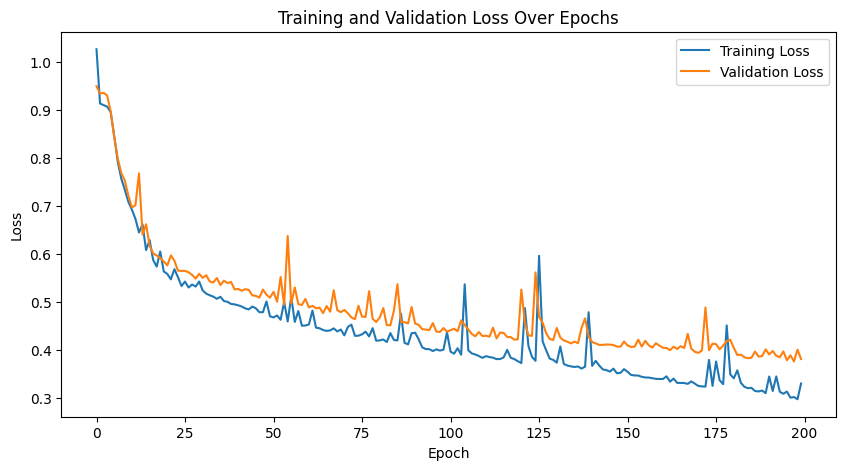

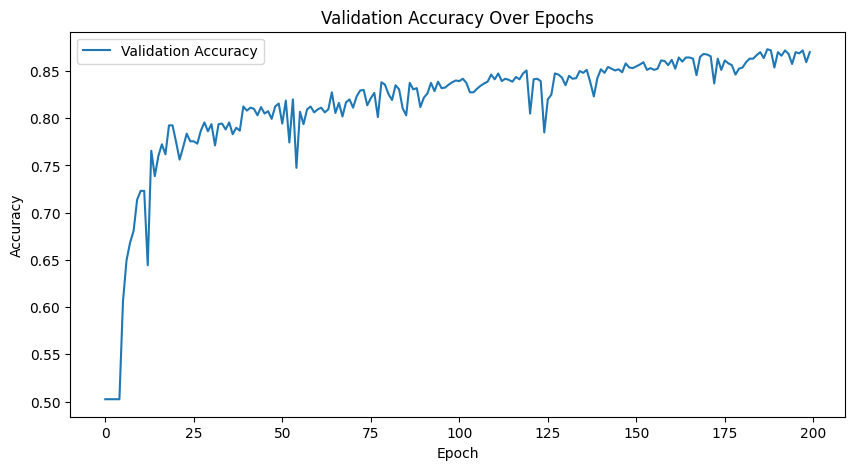

In [18]:

# Set the number of epochs
num_epochs = 200

# Initialize lists to monitor loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_samples = 0
    
    # Training phase
    for sequences, labels in trainloader:
        optimizer.zero_grad()
        sequences = sequences.float()
        
        # Forward pass
        outputs = model(sequences)
        outputs_flat = outputs.view(-1, 3)
        labels_flat = labels.view(-1)
        
        # Calculate loss
        loss = criterion(outputs_flat, labels_flat)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item() * sequences.size(0)
        
        # Calculate total correct predictions
        _, predicted = torch.max(outputs_flat, 1)
        total_correct += (predicted == labels_flat).sum().item()
        total_samples += labels_flat.size(0)
    
    # Average loss for this epoch
    epoch_loss /= len(trainloader.dataset)
    train_losses.append(epoch_loss)

    # Calculate training accuracy
    train_accuracy = total_correct / total_samples
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for sequences, labels in valloader:
            sequences = sequences.float()
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, 3)
            labels_flat = labels.view(-1)
            
            # Calculate validation loss
            val_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            val_correct += (predicted == labels_flat).sum().item()
            val_total += labels_flat.size(0)
    
    # Average validation loss for this epoch
    val_loss /= len(valloader.dataset)
    val_losses.append(val_loss)
    
    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plotting the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()


Now we evaluate on the Test-Set

In [21]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for sequences, labels in testloader:
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, 3)
            labels_flat = labels.view(-1)
            
            # Calculate validation loss
            test_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            test_correct += (predicted == labels_flat).sum().item()
            test_total += labels_flat.size(0)
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8714107365792759
